## For testing only on fMRI data without EEG
replacing train file, still calling functions in engine and model

In [1]:
import os
import time
import pickle
import torch

import numpy as np
import scipy.sparse as sp
from scipy.sparse import linalg
from scipy.signal import butter,filtfilt, zpk2sos, sosfilt
from scipy.stats.stats import pearsonr
from sklearn.utils import shuffle

from Utils import graphTools
from Utils import dataTools
from Utils.CRASH_loader import *
from Utils.util import *
from engine import *

import ipdb
from tqdm import tqdm

In [2]:
np.random.seed(0)
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)
    torch.cuda.empty_cache()

''' args '''
# data and processing configs
adjtype = 'transition'
addaptadj = True
randomadj = True
aptonly = False
gcn_bool = True
scatter = False

tasks = ['rest','VWM-1','VWM-2','VWM-3','DYN-1','DYN-2','DYN-3','DYN-4','DOT','MOD','PVT']
task = tasks[4]
savedir = './garage/CRASH_'+task

# model params
in_dim = 1
nhid = 32
kernel_size = 2
blocks = 3
layers = 2

# training params
dropout = 0.3
learning_rate = 3e-4
weight_decay = 8e-3
batch_size = 64
epochs = 50
print_every = 100
device = torch.device('cuda:0')

## 1. Data

### load data

In [3]:
comn_ids = get_comn_ids(F_only=True)
num_region = 200 # 200 or 400
sc = get_sc(comn_ids, num_region)
fmri = get_fmri(comn_ids, num_region, task)

  9%|▉         | 5/56 [00:00<00:01, 47.60it/s]

loading SC


  0%|          | 0/56 [00:00<?, ?it/s]

loading fMRI


100%|██████████| 56/56 [00:10<00:00,  5.18it/s]

4961a 6 >> No fmri file


(277, 200)

In [9]:
# print fmri shape
for k in fmri:
    if k!= 'time_res':
        for j in fmri[k]:
            print(fmri[k][j].shape)

(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)
(277, 200)

### put data into matrices and process

In [20]:
if task == tasks[0]:
    fmri_len = 326
    cut_out = 5
elif task == tasks[1] or task == tasks[2]:
    fmri_len = 302
    cut_out = 2
elif task == tasks[4]:
    fmri_len = 277
    cut_out = 12

scs = []
fmri_mat = []
adjs = []
for subj in comn_ids:
    for ses in fmri[subj]:
        if ses in sc[subj] and len(fmri[subj][ses]) >= fmri_len:
            scs.append(sc[subj][ses])
            adjs.append(mod_adj(sc[subj][ses], adjtype))
            fmri_mat.append(fmri[subj][ses][cut_out:fmri_len]) # removing the first several frames since they tend to spike

scs = np.stack(scs)
fmri_mat = np.stack(fmri_mat)

print(scs.shape)
print(fmri_mat.shape)

(238, 200, 200)
(238, 265, 200)


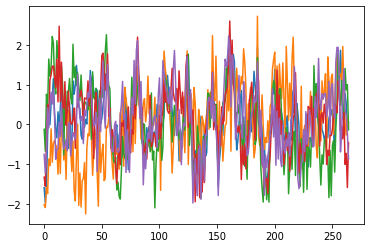

In [21]:
for i in range(5):
    plt.plot(fmri_mat[0,:,i])
plt.show()

In [22]:
# only use the sessions without huge spikes: thresholding at 6
valid_idx = []
for i in range(len(fmri_mat)):
    if np.abs(fmri_mat[i]).max() < 6 : 
        valid_idx.append(i)
#     else: # to visualize invalid ones
#         for j in range(200):
#             plt.plot(fmri_mat[i,:,j])
#         plt.show()

print('valid sessions:', len(valid_idx))

# only keep valid ones
fmri_mat = fmri_mat[valid_idx]
scs = scs[valid_idx]
adjs = [adjs[i] for i in valid_idx]

valid sessions: 191


### choose whether low-pass filter fMRI or not

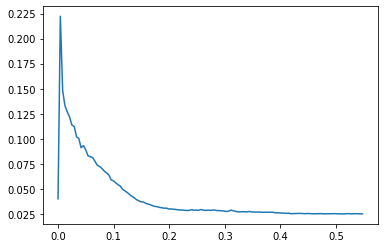

most fMRI f: 0.004146796599626788 Hz, aka 1/ 241.15000000000003 s


In [23]:
''' plot fmri signal in freq domain '''
xf = np.fft.rfftfreq(fmri_mat.shape[1], d=0.91) # up to nyquist freq: 1/2*(1/0.91)
yf = np.zeros_like(xf)
for i in range(len(fmri_mat)):
    for j in range(fmri_mat.shape[-1]):
        tmp = fmri_mat[i, :, j]
        yf += np.abs(np.fft.rfft(tmp) / len(tmp))

yf /= (fmri_mat.shape[0]*fmri_mat.shape[-1])
plt.plot(xf, yf)
plt.show()
highest_f_component = xf[np.where(yf == max(yf))[0][0]]
print('most fMRI f:', highest_f_component, 'Hz, aka 1/', 1/highest_f_component, 's')

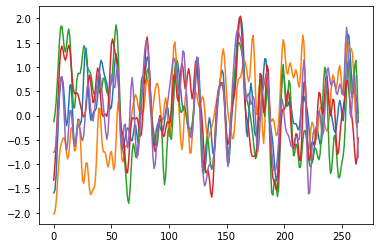

In [26]:
''' low pass filter fMRI with 0.2 hz threshold '''
if task == tasks[0] or task == tasks[4]:
    cutoff = 0.2 #(1/0.91)/(2*3)
elif task == tasks[1] or task == tasks[2]:
    cutoff = 0.25

for i in range(fmri_mat.shape[0]): #fmri_mat: (n, t, 200)
    for j in range(fmri_mat.shape[-1]):
        fmri_mat[i,:,j] = butter_lowpass_filter(fmri_mat[i,:,j], cutoff, 1/0.91)

for i in range(5):
    plt.plot(fmri_mat[0,:,i])
plt.show()

### sliding window to create x-y pairs

In [27]:
window_len = 10
f_stride = 1 # sliding window stride
F_idxer = np.arange(window_len)[None, :] + np.arange(0, fmri_mat.shape[1] - window_len + 1, f_stride)[:, None]
# print(F_idxer)

x_idxer = F_idxer[:-window_len]
y_idxer = F_idxer[window_len:]
print(x_idxer)
print(y_idxer)

_input = fmri_mat[:, x_idxer, :]
_gt = fmri_mat[:, y_idxer, :]
print(_input.shape)
_input = _input.reshape(-1, *_input.shape[2:])
_gt = _gt.reshape(-1, *_gt.shape[2:])
print(_input.shape)

[[  0   1   2 ...   7   8   9]
 [  1   2   3 ...   8   9  10]
 [  2   3   4 ...   9  10  11]
 ...
 [243 244 245 ... 250 251 252]
 [244 245 246 ... 251 252 253]
 [245 246 247 ... 252 253 254]]
[[ 10  11  12 ...  17  18  19]
 [ 11  12  13 ...  18  19  20]
 [ 12  13  14 ...  19  20  21]
 ...
 [253 254 255 ... 260 261 262]
 [254 255 256 ... 261 262 263]
 [255 256 257 ... 262 263 264]]
(191, 246, 10, 200)
(46986, 10, 200)


In [28]:
'''randomize SC entries to see the sensitivity to SC'''
if False:
    import networkx as nx
    # use completely random SC w/ same level of sparsity
    n = _input.shape[-1] # number of nodes
    p = np.count_nonzero(adj_mx[0][0]) / (n*(n-1)/2) # probability for edge creation
    _G = nx.gnp_random_graph(n, p)
    # _G = nx.newman_watts_strogatz_graph(n,5,p)
    # _G = nx.gnm_random_graph(n, np.count_nonzero(adj_mx[0][0]))
    for i in range(len(adj_mx)):
        # _G = nx.gnp_random_graph(n, p)
        adj_mx[i] = mod_adj(nx.to_numpy_matrix(_G), adjtype)

In [29]:
def proc_helper(a, b, len_adj, no_scaler=False):
    assert len(a) == len(b), 'input length do not match'
    assert len(a) % len_adj == 0

    # deal with adj_mx repetitions (using idx)
    adj_mx_idx = np.arange(len_adj).repeat(len(a)//len_adj)
    # shuffle for mixing different subjects' image
    adj_mx_idx, a, b = shuffle(adj_mx_idx, a, b, random_state = 0)
    # train-val-test split
    num_total = len(a)
    nTrain = round(0.7 * num_total)
    nValid = round(0.15 * num_total)
    nTest = num_total - nTrain - nValid
    print('Train, Val, Test numbers:', nTrain, nValid, nTest)

    if no_scaler:
        return nTrain, nValid, nTest, a, b, None, None, adj_mx_idx
    
    # # overall scaler
    # scaler_a = util.StandardScaler(mean=a[:nTrain].mean(), std=a[:nTrain].std())
    # a = scaler_a.transform(a)
    ### TODO: fmri alone can only use train data for the scaler, revise here

    # per-feature standardization
    scaler_a = StandardScaler(a.mean((0,1)), a.std((0,1)))
    
    a = scaler_a.transform(a.reshape(-1, a.shape[-1])).reshape(a.shape)
    return nTrain, nValid, nTest, a, b, scaler_a, adj_mx_idx

In [30]:
nTrain, nValid, nTest, _input, _gt, scaler_x, adj_mx_idx = proc_helper(_input, _gt, len(adjs))

Train, Val, Test numbers: 32890 7048 7048


### adj related init

In [31]:
# separate adj matrices into train-val-test samples
# ipdb.set_trace() # shuffle adj to test rand adj's influence

_adj = [[] for i in range(len(adjs[0]))]
for a in adjs:
    for i in range(len(_adj)):
        _adj[i].append(a[i])
adjs = [np.stack(np.asarray(i)) for i in _adj]

supports = {}
supports['train'] = supports['val'] = supports['test'] = adjs

adjinit = None
if addaptadj:
    adjinit = {}
    if randomadj:
        adjinit['train'] = adjinit['val'] = adjinit['test'] = None
    else:
        adjinit['train'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[:nTrain]]) 
        adjinit['val'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[nTrain:-nTest]])
        adjinit['test'] = np.concatenate([adjs[c][0][None,...] for c in adj_mx_idx[-nTest:]])

    if aptonly:
        supports = None

## 2. Training and validation

### create engine

In [32]:
engine = trainer(scaler_x, in_dim, window_len, _input.shape[-1], nhid, 
                 dropout, learning_rate, weight_decay, device, 
                 supports, gcn_bool, addaptadj, adjinit, kernel_size,
                 blocks, layers, out_nodes=_gt.shape[-1], F_t=1,
                 subsample=False, F_only=True, batch_size=batch_size)

gwnet_diff_G_Fonly(
  (filter_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (1): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (2): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (3): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (4): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (5): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
  )
  (gate_convs): ModuleList(
    (0): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (1): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (2): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (3): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 2), dilation=(1, 2))
    (4): Conv1d(32, 32, kernel_size=(1, 2), stride=(1,), padding=(0, 1))
    (5): Conv1d(32, 32, kernel

### train-val loop

In [33]:
print("start training...",flush=True)

his_loss_train = []
his_loss_val =[]
val_time = []
train_time = []
min_loss = float('Inf')
grads = []

for i in range(1, epochs+1):
    # if i % 50 == 0:
    #     # lr = max(0.000002, learning_rate * (0.1 ** (i // 10)))
    #     for g in engine.optimizer.param_groups:
    #         g['lr'] *= 0.9

    train_loss = []
    train_mae = []
    train_mape = []
    train_rmse = []
    t1 = time.time()
    engine.set_state('train')
    x = _input[:nTrain]
    y = _gt[:nTrain]
    adj_idx = adj_mx_idx[:nTrain]
    if scatter:
        _coeffs = coeffs[:nTrain]

    # # for overfitting
    # x = _input
    # y = _gt
    # adj_idx = adj_mx_idx
    # if scatter:
    #     _coeffs = coeffs

    iter = 0
    # shuffle in-out-adj_idx
    if addaptadj:
        if not randomadj:
            # adjinit['train'] need to be shuffled with train set
            if scatter:
                x, y, adj_idx, _coeffs, adjinit['train'] = shuffle(x, y, adj_idx, _coeffs, adjinit['train'])
            else:
                x, y, adj_idx, adjinit['train'] = shuffle(x, y, adj_idx, adjinit['train'])
    else:
        if scatter:
            x, y, adj_idx, _coeffs = shuffle(x, y, adj_idx, _coeffs)
        else:
            x, y, adj_idx = shuffle(x, y, adj_idx)

    # shuffle y, to test if model really learns anything (~random output)
    # y = shuffle(y)

    for batch_i in range(nTrain//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
        if scatter:
            # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
            # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
            # _y = torch.Tensor(_y).to(device)
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
            coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

            _y = [_y.transpose(1,2), coeff_y]
        else:
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        metrics = engine.train_CRASH(_x, _y, None, {}, _adj_idx) # region assignment temporarily use {}, TODO: pooling

        train_loss.append(metrics[0])
        train_mae.append(metrics[1])
        train_mape.append(metrics[2])
        train_rmse.append(metrics[3])
        # grads.append(metrics[4])
        if iter % print_every == 0 :
            log = 'Iter: {:03d}, Train Loss: {:.6f}, Train MAE: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}'
            print(log.format(iter, train_loss[-1], train_mae[-1], train_mape[-1], train_rmse[-1]),flush=True)
        iter += 1
        # break # overfit single batch

    t2 = time.time()
    train_time.append(t2-t1)

    #validation
    valid_loss = []
    valid_mae = []
    valid_mape = []
    valid_rmse = []
    valid_cc = []

    s1 = time.time()
    engine.set_state('val')
    x = _input[nTrain:nTrain+nValid]
    y = _gt[nTrain:nTrain+nValid]
    adj_idx = adj_mx_idx[nTrain:nTrain+nValid]
    if scatter:
        _coeffs = coeffs[nTrain:nTrain+nValid]

    # # for overfitting
    # x = _input
    # y = _gt
    # adj_idx = adj_mx_idx
    # if scatter:
    #     _coeffs = coeffs

    for batch_i in range(nValid//batch_size):
        _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
        _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
        if scatter:
            # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
            # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
            # _y = torch.Tensor(_y).to(device)
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
            coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

            _y = [_y.transpose(1,2), coeff_y]
        else:
            _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        if batch_i == 0: # only viz the first one
            metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx, viz=False)
        else:
            metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx)
        valid_loss.append(metrics[0])
        valid_mae.append(metrics[1])
        valid_mape.append(metrics[2])
        valid_rmse.append(metrics[3])
        valid_cc.append(metrics[4])

        # plt.plot(metrics[-1][...,order0,:][0,0,0,0].cpu().numpy())
        # plt.show()
        #     break # overfit single batch
        # break

    s2 = time.time()
    log = 'Epoch: {:03d}, Inference Time: {:.4f} secs'
    print(log.format(i,(s2-s1)))
    val_time.append(s2-s1)

    mtrain_loss = np.mean(train_loss)
    mtrain_mae = np.mean(train_mae)
    mtrain_mape = np.mean(train_mape)
    mtrain_rmse = np.mean(train_rmse)

    mvalid_loss = np.mean(valid_loss)
    mvalid_mae = np.mean(valid_mae)
    mvalid_mape = np.mean(valid_mape)
    mvalid_rmse = np.mean(valid_rmse)
    mvalid_cc = np.mean(valid_cc)
    his_loss_train.append(mtrain_loss)
    his_loss_val.append(mvalid_loss)

    log = 'Epoch: {:03d}, Train Loss: {:.6f}, Train MAE: {:.4f}, Train MAPE: {:.4f}, Train RMSE: {:.4f}, Valid Loss: {:.6f}, Valid MAE: {:.4f}, Valid MAPE: {:.4f}, Valid RMSE: {:.4f}, Valid CC: {:.4f}, Training Time: {:.4f}/epoch'
    print(log.format(i, mtrain_loss, mtrain_mae, mtrain_mape, mtrain_rmse, mvalid_loss, mvalid_mae, mvalid_mape, mvalid_rmse, mvalid_cc, (t2 - t1)),flush=True)
    # only save the best
    if mvalid_loss < min_loss:
        min_loss = mvalid_loss
        # # remove previous
        # fname = glob.glob(savedir+'_epoch_*.pth')
        # for f in fname:
        #     os.remove(f)
        # save new
        torch.save(engine.model.state_dict(), savedir+"_epoch_"+str(i)+"_"+str(round(mvalid_loss,2))+".pth")
    # torch.save(engine.model.state_dict(), savedir+"_epoch_"+str(i)+"_"+str(round(mvalid_loss,2))+".pth")
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time))) 

start training...
Iter: 000, Train Loss: 0.756708, Train MAE: 0.6950, Train MAPE: -0.0672, Train RMSE: 0.8699
Iter: 100, Train Loss: 0.535145, Train MAE: 0.5563, Train MAPE: 0.5137, Train RMSE: 0.7315
Iter: 200, Train Loss: 0.544229, Train MAE: 0.5554, Train MAPE: 1.0185, Train RMSE: 0.7377
Iter: 300, Train Loss: 0.484277, Train MAE: 0.5244, Train MAPE: 1.3816, Train RMSE: 0.6959
Iter: 400, Train Loss: 0.506000, Train MAE: 0.5256, Train MAPE: -2.0390, Train RMSE: 0.7113
Iter: 500, Train Loss: 0.509399, Train MAE: 0.5303, Train MAPE: 0.1063, Train RMSE: 0.7137
Epoch: 001, Inference Time: 296.4959 secs
Epoch: 001, Train Loss: 0.524484, Train MAE: 0.5465, Train MAPE: 1.0040, Train RMSE: 0.7232, Valid Loss: 0.493213, Valid MAE: 0.5237, Valid MAPE: 0.9459, Valid RMSE: 0.7019, Valid CC: 0.3627, Training Time: 40.2643/epoch
Iter: 000, Train Loss: 0.553985, Train MAE: 0.5536, Train MAPE: -0.1636, Train RMSE: 0.7443
Iter: 100, Train Loss: 0.488319, Train MAE: 0.5185, Train MAPE: 0.1591, Train R

Iter: 100, Train Loss: 0.485342, Train MAE: 0.5205, Train MAPE: 0.3206, Train RMSE: 0.6967
Iter: 200, Train Loss: 0.516581, Train MAE: 0.5416, Train MAPE: 0.9553, Train RMSE: 0.7187
Iter: 300, Train Loss: 0.461244, Train MAE: 0.5098, Train MAPE: 1.1637, Train RMSE: 0.6791
Iter: 400, Train Loss: 0.505261, Train MAE: 0.5293, Train MAPE: -2.4521, Train RMSE: 0.7108
Iter: 500, Train Loss: 0.503030, Train MAE: 0.5306, Train MAPE: 0.0622, Train RMSE: 0.7092
Epoch: 011, Inference Time: 293.0661 secs
Epoch: 011, Train Loss: 0.491906, Train MAE: 0.5270, Train MAPE: 1.2102, Train RMSE: 0.7008, Valid Loss: 0.493850, Valid MAE: 0.5317, Valid MAPE: 1.1248, Valid RMSE: 0.7023, Valid CC: 0.2927, Training Time: 40.1737/epoch
Iter: 000, Train Loss: 0.545512, Train MAE: 0.5512, Train MAPE: 0.0411, Train RMSE: 0.7386
Iter: 100, Train Loss: 0.485412, Train MAE: 0.5195, Train MAPE: 0.1389, Train RMSE: 0.6967
Iter: 200, Train Loss: 0.514708, Train MAE: 0.5405, Train MAPE: 0.1427, Train RMSE: 0.7174
Iter: 30

Iter: 200, Train Loss: 0.504052, Train MAE: 0.5357, Train MAPE: 0.2367, Train RMSE: 0.7100
Iter: 300, Train Loss: 0.445941, Train MAE: 0.5025, Train MAPE: 0.6252, Train RMSE: 0.6678
Iter: 400, Train Loss: 0.492081, Train MAE: 0.5210, Train MAPE: -2.6640, Train RMSE: 0.7015
Iter: 500, Train Loss: 0.496401, Train MAE: 0.5262, Train MAPE: 0.1065, Train RMSE: 0.7046
Epoch: 021, Inference Time: 292.4539 secs
Epoch: 021, Train Loss: 0.484881, Train MAE: 0.5228, Train MAPE: 1.0485, Train RMSE: 0.6958, Valid Loss: 0.484352, Valid MAE: 0.5229, Valid MAPE: 0.9781, Valid RMSE: 0.6956, Valid CC: 0.2947, Training Time: 40.3019/epoch
Iter: 000, Train Loss: 0.537494, Train MAE: 0.5456, Train MAPE: -0.1991, Train RMSE: 0.7331
Iter: 100, Train Loss: 0.479915, Train MAE: 0.5156, Train MAPE: 0.4595, Train RMSE: 0.6928
Iter: 200, Train Loss: 0.505591, Train MAE: 0.5361, Train MAPE: 0.4885, Train RMSE: 0.7110
Iter: 300, Train Loss: 0.448580, Train MAE: 0.5041, Train MAPE: 0.6909, Train RMSE: 0.6698
Iter: 4

Iter: 300, Train Loss: 0.444575, Train MAE: 0.4998, Train MAPE: 0.7752, Train RMSE: 0.6668
Iter: 400, Train Loss: 0.488108, Train MAE: 0.5194, Train MAPE: -3.1158, Train RMSE: 0.6986
Iter: 500, Train Loss: 0.494223, Train MAE: 0.5248, Train MAPE: 0.0428, Train RMSE: 0.7030
Epoch: 031, Inference Time: 293.3471 secs
Epoch: 031, Train Loss: 0.482008, Train MAE: 0.5208, Train MAPE: 0.9929, Train RMSE: 0.6937, Valid Loss: 0.477305, Valid MAE: 0.5174, Valid MAPE: 0.8706, Valid RMSE: 0.6905, Valid CC: 0.2932, Training Time: 40.2363/epoch
Iter: 000, Train Loss: 0.533016, Train MAE: 0.5431, Train MAPE: -0.2011, Train RMSE: 0.7301
Iter: 100, Train Loss: 0.479203, Train MAE: 0.5151, Train MAPE: 0.5366, Train RMSE: 0.6922
Iter: 200, Train Loss: 0.505531, Train MAE: 0.5366, Train MAPE: 0.7813, Train RMSE: 0.7110
Iter: 300, Train Loss: 0.443964, Train MAE: 0.4997, Train MAPE: 0.4643, Train RMSE: 0.6663
Iter: 400, Train Loss: 0.484926, Train MAE: 0.5173, Train MAPE: -2.9345, Train RMSE: 0.6964
Iter: 

Iter: 400, Train Loss: 0.487696, Train MAE: 0.5177, Train MAPE: -3.1490, Train RMSE: 0.6984
Iter: 500, Train Loss: 0.490951, Train MAE: 0.5225, Train MAPE: 0.0750, Train RMSE: 0.7007
Epoch: 041, Inference Time: 295.3499 secs
Epoch: 041, Train Loss: 0.480643, Train MAE: 0.5197, Train MAPE: 1.0664, Train RMSE: 0.6927, Valid Loss: 0.471005, Valid MAE: 0.5110, Valid MAPE: 0.8161, Valid RMSE: 0.6859, Valid CC: 0.2952, Training Time: 40.2750/epoch
Iter: 000, Train Loss: 0.533299, Train MAE: 0.5428, Train MAPE: -0.3362, Train RMSE: 0.7303
Iter: 100, Train Loss: 0.477474, Train MAE: 0.5133, Train MAPE: 0.3271, Train RMSE: 0.6910
Iter: 200, Train Loss: 0.506317, Train MAE: 0.5368, Train MAPE: 1.5524, Train RMSE: 0.7116
Iter: 300, Train Loss: 0.444370, Train MAE: 0.5000, Train MAPE: 0.4664, Train RMSE: 0.6666
Iter: 400, Train Loss: 0.484944, Train MAE: 0.5168, Train MAPE: -2.6433, Train RMSE: 0.6964
Iter: 500, Train Loss: 0.491066, Train MAE: 0.5229, Train MAPE: 0.1016, Train RMSE: 0.7008
Epoch:

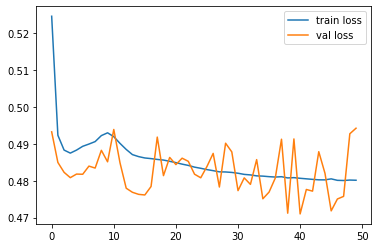

In [34]:
plt.plot(his_loss_train, label='train loss')
plt.plot(his_loss_val, label='val loss')
plt.legend()
plt.show()
# ipdb.set_trace() #tmp1 = [i[0] for i in grads] # plot his_loss_train and his_loss_val
his_loss = his_loss_val

### test and visualizations

In [36]:
# loading pretrained models if have
model_name = 'garage/CRASH_DYN-1_epoch_41_0.47.pth'
pretrained_dict = torch.load(model_name)

model_dict = engine.model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict) 
engine.model.load_state_dict(model_dict)

<All keys matched successfully>

  0%|          | 0/110 [00:00<?, ?it/s]

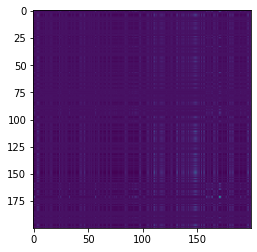

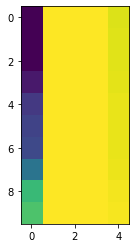

> /home/sikun/Documents/Graph-WaveNet/model.py(849)forward()
    848 
--> 849             if len(supports) > 0:
    850                 new_supports = supports + [adp]

ipdb> c


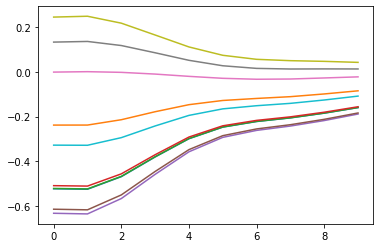

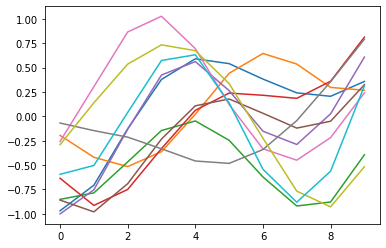

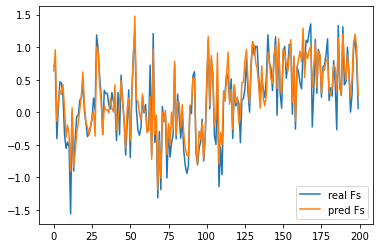

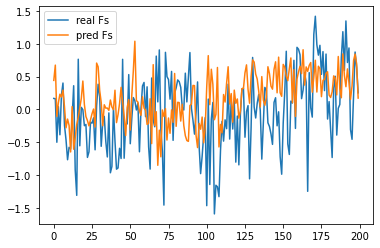

> <ipython-input-37-92c106cac3ec>(19)<module>()
     18 
---> 19 for batch_i in tqdm(range(nTest//batch_size)):
     20     _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]

ipdb> c


100%|██████████| 110/110 [06:08<00:00,  3.35s/it]


In [37]:
# testing
amae = []
amape = []
armse = []
a_cc = []

real_Fs = []
pred_Fs = []
pred_coeffs = []
adpa = []

engine.set_state('test')
x = _input[-nTest:]
y = _gt[-nTest:]
adj_idx = adj_mx_idx[-nTest:]
if scatter:
    _coeffs = coeffs[-nTest:]

for batch_i in tqdm(range(nTest//batch_size)):
    _adj_idx = adj_idx[batch_i * batch_size: (batch_i + 1) * batch_size]
    _x = torch.Tensor(x[batch_i * batch_size: (batch_i + 1) * batch_size][...,None]).to(device).transpose(1, 3)
    if scatter:
        # _y = y[batch_i * args.batch_size: (batch_i + 1) * args.batch_size]
        # coeff_y = torch.Tensor(scattering(_y.transpose(0,2,1))).to(device)
        # _y = torch.Tensor(_y).to(device)
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)
        coeff_y  = torch.Tensor(_coeffs[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

        _y = [_y.transpose(1,2), coeff_y]
    else:
        _y = torch.Tensor(y[batch_i * batch_size: (batch_i + 1) * batch_size]).to(device)

    if batch_i == 0: # only viz the first one
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx, viz=True)
    else:
        metrics = engine.eval_CRASH(_x, _y, None, {}, _adj_idx)

    amae.append(metrics[1])
    amape.append(metrics[2])
    armse.append(metrics[3])
    adpa.append(metrics[5])

    real_Fs.append(_y)
    pred_Fs.append(metrics[-3])
    
    if scatter:
        pred_coeffs.append(metrics[-1])

    if batch_i == 0:
        if scatter:
            # for in-network scatter checking
            # ipdb.set_trace()
            plt.figure('sig')
            plt.plot(real_Es[0][0].squeeze().cpu().numpy()[1,1], label='real')
            plt.plot(pred_Es[0].squeeze().cpu().numpy()[1,1], label='pred')
            plt.legend()
            # plt.savefig('sig.png')

            plt.figure('coeff')
            # plt.plot(real_Es[0][1].squeeze().cpu().numpy()[0,0], label='real')
            # plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[0,0], label='pred')
            plt.plot(real_Es[0][1].squeeze().cpu().numpy()[1,1,0], label='real')
            plt.plot(pred_coeffs[0].squeeze().cpu().numpy()[1,1,0], label='pred')
            plt.legend()
            # plt.savefig('coeff.png')
            plt.show()
            ipdb.set_trace()   

        else:
            plt.figure(0) # timestep 0
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,0], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,0], label='pred Fs')
            plt.legend()
            plt.show()
            plt.figure(1) # timestep 3
            plt.plot(real_Fs[0].squeeze().cpu().numpy()[3,3], label='real Fs')
            plt.plot(pred_Fs[0].squeeze().cpu().numpy()[3,3], label='pred Fs')
            plt.legend()
            plt.show()                       
            ipdb.set_trace()

In [38]:
torch.cat(adpa).cpu().numpy().shape

(7040, 200, 200)

In [39]:
np.save('adaptive_adj_F_'+task+'.npy', torch.cat(adpa).cpu().numpy())